In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [19]:
df = pd.read_csv('../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

In [20]:
def MARE(prediction_tensor, truth_tensor):
    return torch.sum(torch.abs((prediction_tensor - truth_tensor)/truth_tensor))/truth_tensor.numel()

In [21]:
from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [22]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('1min').mean()

In [23]:
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [24]:
# def create_sequences(data, seq_length):
#     """
#     Creates sequences and their corresponding target sequences from the input data.

#     Args:
#         data (array-like): The input data.
#         seq_length (int): The length of each sequence.

#     Returns:
#         np.ndarray: Array of input sequences.
#         np.ndarray: Array of target sequences.
#     """
#     if len(data) < 2 * seq_length:
#         raise ValueError("Data length must be at least twice the sequence length.")

#     sequences = []
#     targets = []
    
#     for i in range(len(data) - 2 * seq_length + 1):
#         sequences.append(data[i:i+seq_length])               # Input sequence
#         targets.append(data[i+seq_length:i+2*seq_length])    # Target sequence of same length
    
#     return np.array(sequences), np.array(targets)


In [25]:
def create_sequences(data, seq_length):
    """
    Creates sequences and their corresponding target sequences from the input data.
    The target sequence is half the size of the training sequence.

    Args:
        data (array-like): The input data.
        seq_length (int): The length of each training sequence.

    Returns:
        np.ndarray: Array of input sequences.
        np.ndarray: Array of target sequences (half the length of input sequences).
    """
    target_length = seq_length // 3  # Target is half the size of the training sequence

    if len(data) < seq_length + target_length:
        raise ValueError("Data length must be at least seq_length + target_length.")

    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length - target_length + 1):
        sequences.append(data[i:i+seq_length])                        # Input sequence
        targets.append(data[i+seq_length:i+seq_length+target_length]) # Target sequence

    return np.array(sequences), np.array(targets)


In [26]:
# data piece 1

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(first_piece)
train_df1 =first_piece
# val_df1 = first_piece[int(n*0.4):]
# test_df1 = first_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean1 = train_df1.mean()
train_std1 = train_df1.std()

train_df1 = (train_df1 - train_mean1) / train_std1
# val_df1 = (val_df1 - train_mean1) / train_std1

# make sequences
train_seq1, train_labels1 = create_sequences(train_df1.values, 90)
# val_seq1, val_labels1 = create_sequences(val_df1.values, 60)

# make tensors
train_seq_tensor1 = torch.FloatTensor(train_seq1).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor1 = torch.FloatTensor(train_labels1).to(device='cuda') # (batch, output_dim)
# val_seq_tensor1 = torch.FloatTensor(val_seq1).to(device='cuda')  # (batch, seq_length, input_dim)
# val_label_tensor1 = torch.FloatTensor(val_labels1).to(device='cuda')  # (batch, output_dim)


In [27]:
train_seq_tensor1.shape

torch.Size([842, 90, 1])

In [28]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(second_piece)
train_df2 =second_piece[0:int(n*0.8)]
val_df2 = second_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean2 = train_df2.mean()
train_std2 = train_df2.std()

train_df2 = (train_df2 - train_mean2) / train_std2
val_df2 = (val_df2 - train_mean2) / train_std2

# make sequences
train_seq2, train_labels2 = create_sequences(train_df2.values, 90)
val_seq2, val_labels2 = create_sequences(val_df2.values, 90)

# make tensors
train_seq_tensor2 = torch.FloatTensor(train_seq2).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor2 = torch.FloatTensor(train_labels2).to(device='cuda') # (batch, output_dim)
val_seq_tensor2 = torch.FloatTensor(val_seq2).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor2 = torch.FloatTensor(val_labels2).to(device='cuda')  # (batch, output_dim)

In [29]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(third_piece)
train_df3 = third_piece[0:int(n*0.8)]
val_df3 = third_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean3 = train_df3.mean()
train_std3 = train_df3.std()

train_df3 = (train_df3 - train_mean3) / train_std3
val_df3 = (val_df3 - train_mean3) / train_std3

# make sequences
train_seq3, train_labels3 = create_sequences(train_df3.values, 90)
val_seq3, val_labels3 = create_sequences(val_df3.values, 90)

# make tensors
train_seq_tensor3 = torch.FloatTensor(train_seq3).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor3 = torch.FloatTensor(train_labels3).to(device='cuda') # (batch, output_dim)
val_seq_tensor3 = torch.FloatTensor(val_seq3).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor3 = torch.FloatTensor(val_labels3).to(device='cuda')  # (batch, output_dim)

In [30]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(fourth_piece)
train_df4 = fourth_piece[0:int(n*0.8)]
val_df4 = fourth_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean4 = train_df4.mean()
train_std4 = train_df4.std()

train_df4 = (train_df4 - train_mean4) / train_std4
val_df4 = (val_df4 - train_mean4) / train_std4

# make sequences
train_seq4, train_labels4 = create_sequences(train_df4.values, 90)
val_seq4, val_labels4 = create_sequences(val_df4.values, 90)

# make tensors
train_seq_tensor4 = torch.FloatTensor(train_seq4).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor4 = torch.FloatTensor(train_labels4).to(device='cuda') # (batch, output_dim)
val_seq_tensor4 = torch.FloatTensor(val_seq4).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor4 = torch.FloatTensor(val_labels4).to(device='cuda')  # (batch, output_dim)

In [31]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.do = nn.Dropout()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        # out = self.do(out)
        out = self.fc(out[:, -30:, :])  # Take the last 30 time step output
        return out

# Model parameters
input_dim = 1
hidden_dim = 256
num_layers = 3
output_dim = 1

# Instantiate model
model1 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model1 = model1.to("cuda")  # Use "cuda" if you have a GPU

model2 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model2 = model2.to("cuda")  # Use "cuda" if you have a GPU

model3 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model3 = model3.to("cuda")  # Use "cuda" if you have a GPU

criterion1 = nn.SmoothL1Loss()
optimizer1 = optim.Adam(model1.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer1, step_size=10, gamma=0.8)

criterion2 = nn.SmoothL1Loss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.0001)
criterion3 = nn.SmoothL1Loss()
optimizer3 = optim.Adam(model3.parameters(), lr=0.0001)

In [32]:
# Train model 1
num_epochs = 800
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model1.train()
    
    optimizer1.zero_grad()
    y_pred = model1(train_seq_tensor1)
    # print(y_pred.shape)
    # print(train_label_tensor1.shape)
    
    loss = criterion1(y_pred, train_label_tensor1)
    loss.backward()
    optimizer1.step()
    
    train_losses.append(loss.item())

    # Validation
    # model1.eval()
    # with torch.no_grad():
    #     y_val = model1(val_seq_tensor1)
    #     val_loss = criterion1(y_val, val_label_tensor1)
    #     val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}')

Epoch 0, Train Loss: 0.47738468647003174
Epoch 10, Train Loss: 0.4654192328453064
Epoch 20, Train Loss: 0.43651893734931946
Epoch 30, Train Loss: 0.33208343386650085
Epoch 40, Train Loss: 0.1372719556093216
Epoch 50, Train Loss: 0.12379376590251923
Epoch 60, Train Loss: 0.12148783355951309
Epoch 70, Train Loss: 0.11975052952766418
Epoch 80, Train Loss: 0.11731100082397461
Epoch 90, Train Loss: 0.11583225429058075
Epoch 100, Train Loss: 0.11486002802848816
Epoch 110, Train Loss: 0.11398786306381226
Epoch 120, Train Loss: 0.11305614560842514
Epoch 130, Train Loss: 0.11203430593013763
Epoch 140, Train Loss: 0.110866479575634
Epoch 150, Train Loss: 0.10949923098087311
Epoch 160, Train Loss: 0.10783815383911133
Epoch 170, Train Loss: 0.10577180981636047
Epoch 180, Train Loss: 0.10311019420623779
Epoch 190, Train Loss: 0.09964911639690399
Epoch 200, Train Loss: 0.0950547605752945
Epoch 210, Train Loss: 0.08620186150074005
Epoch 220, Train Loss: 0.07588064670562744
Epoch 230, Train Loss: 0.05

In [33]:
train_label_tensor1.shape

torch.Size([842, 30, 1])

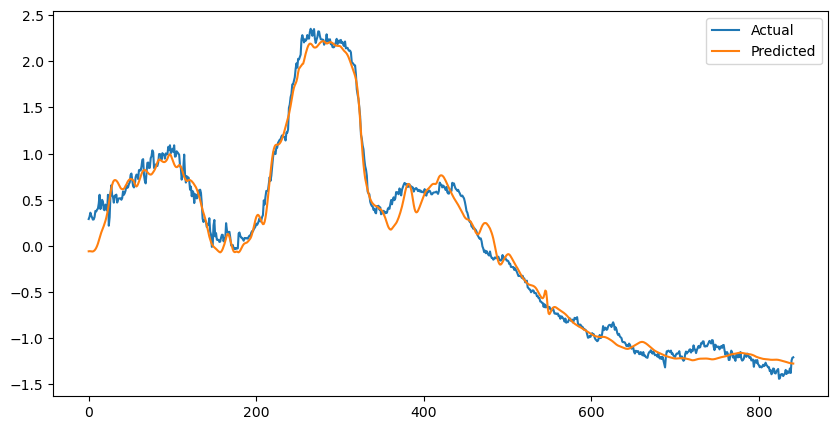

In [34]:
model1.eval()
with torch.no_grad():
    y_pred_test = model1(train_seq_tensor1)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(train_label_tensor1[:, 1,:].cpu().numpy(), label="Actual")
plt.plot(y_pred_test[:, 1, :].cpu().numpy(), label="Predicted")
plt.legend()


In [35]:
# Train model 2
num_epochs = 800
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model2.train()
    
    optimizer2.zero_grad()
    y_pred = model2(train_seq_tensor2)
    
    loss = criterion2(y_pred, train_label_tensor2)
    loss.backward()
    optimizer2.step()
    
    train_losses.append(loss.item())

    # Validation
    model2.eval()
    with torch.no_grad():
        y_val = model2(val_seq_tensor2)
        val_loss = criterion2(y_val, val_label_tensor2)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

Epoch 0, Train Loss: 0.4463178217411041, Val Loss: 1.4745919704437256
Epoch 10, Train Loss: 0.43266233801841736, Val Loss: 1.5099940299987793
Epoch 20, Train Loss: 0.4096927046775818, Val Loss: 1.511368989944458
Epoch 30, Train Loss: 0.3368021249771118, Val Loss: 1.3921751976013184
Epoch 40, Train Loss: 0.2176356315612793, Val Loss: 0.9469490051269531
Epoch 50, Train Loss: 0.14369148015975952, Val Loss: 0.22106342017650604
Epoch 60, Train Loss: 0.12403392791748047, Val Loss: 0.11515361815690994
Epoch 70, Train Loss: 0.12483420222997665, Val Loss: 0.11040647327899933
Epoch 80, Train Loss: 0.1219061091542244, Val Loss: 0.06311280280351639
Epoch 90, Train Loss: 0.11994993686676025, Val Loss: 0.13142108917236328
Epoch 100, Train Loss: 0.11893594264984131, Val Loss: 0.110054150223732
Epoch 110, Train Loss: 0.11788830161094666, Val Loss: 0.10192848742008209
Epoch 120, Train Loss: 0.11690157651901245, Val Loss: 0.09599903225898743
Epoch 130, Train Loss: 0.11586885899305344, Val Loss: 0.094014

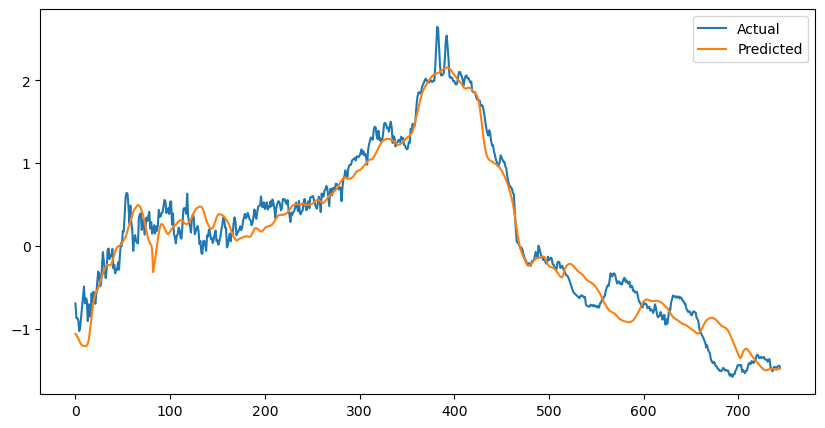

In [36]:
model2.eval()
with torch.no_grad():
    y_pred_test = model2(train_seq_tensor2)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(train_label_tensor2[:, 1,:].cpu().numpy(), label="Actual")
plt.plot(y_pred_test[:, 1, :].cpu().numpy(), label="Predicted")
plt.legend()

In [37]:
# Train model 3
num_epochs = 800
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model3.train()
    
    optimizer3.zero_grad()
    y_pred = model3(train_seq_tensor3)
    
    loss = criterion3(y_pred, train_label_tensor3)
    loss.backward()
    optimizer3.step()
    
    train_losses.append(loss.item())

    # Validation
    model3.eval()
    with torch.no_grad():
        y_val = model3(val_seq_tensor3)
        val_loss = criterion3(y_val, val_label_tensor3)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

Epoch 0, Train Loss: 0.4688890874385834, Val Loss: 0.5912641882896423
Epoch 10, Train Loss: 0.44855833053588867, Val Loss: 0.6431201696395874
Epoch 20, Train Loss: 0.41296783089637756, Val Loss: 0.6917219758033752
Epoch 30, Train Loss: 0.32145455479621887, Val Loss: 0.7000312209129333
Epoch 40, Train Loss: 0.24104730784893036, Val Loss: 0.40518009662628174
Epoch 50, Train Loss: 0.1673617959022522, Val Loss: 0.04686479642987251
Epoch 60, Train Loss: 0.16383616626262665, Val Loss: 0.030187612399458885
Epoch 70, Train Loss: 0.15572461485862732, Val Loss: 0.05908290296792984
Epoch 80, Train Loss: 0.15042075514793396, Val Loss: 0.03953080251812935
Epoch 90, Train Loss: 0.1481603980064392, Val Loss: 0.041915904730558395
Epoch 100, Train Loss: 0.14588887989521027, Val Loss: 0.045684315264225006
Epoch 110, Train Loss: 0.14351582527160645, Val Loss: 0.039260972291231155
Epoch 120, Train Loss: 0.14117135107517242, Val Loss: 0.039583832025527954
Epoch 130, Train Loss: 0.13872641324996948, Val Los

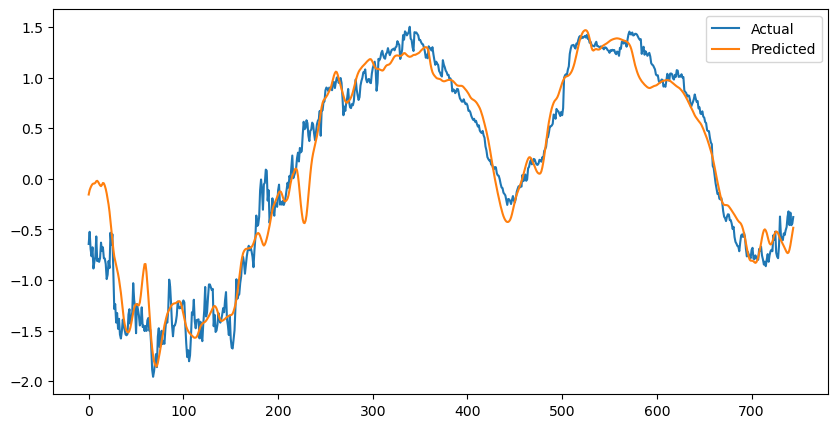

In [38]:
model3.eval()
with torch.no_grad():
    y_pred_test = model3(train_seq_tensor3)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(train_label_tensor3[:, 1,:].cpu().numpy(), label="Actual")
plt.plot(y_pred_test[:, 1, :].cpu().numpy(), label="Predicted")
plt.legend()


In [39]:
import copy
# Average the models
average_model = copy.deepcopy(model1)
models = [model1, model2, model3]
# Compute the average of the parameters
with torch.no_grad():
    for params in zip(*[model.parameters() for model in models]):  # Iterate over corresponding parameters
        avg_param = sum(params) / len(models)  # Element-wise average
        params[0].copy_(avg_param)  # Assign averaged value to the first model (used as reference)

# The `average_model` now has the averaged parameters

In [40]:
# Normalize the data (each partition separately)
test_mean4 = (train_mean1 + train_mean2 + train_mean3 + train_mean4)/4
test_std = (train_std1 + train_std2 + train_std3 + train_std4)/4
test_df = fourth_piece
test_df = (test_df - test_mean4)/test_std

In [41]:
test_seq4, test_labels4 = create_sequences(test_df.values, 90)
test_tensor_seq4 = torch.FloatTensor(test_seq4).to(device='cuda')
test_tensor_labels4 = torch.FloatTensor(test_labels4).to(device='cuda')

In [42]:
test_tensor_seq4[1]

tensor([[-0.2086],
        [-0.1431],
        [-0.0329],
        [-0.0218],
        [ 0.1195],
        [ 0.0021],
        [ 0.0437],
        [-0.0038],
        [ 0.0818],
        [ 0.3244],
        [ 0.3317],
        [ 0.4369],
        [ 0.1545],
        [ 0.2816],
        [ 0.3122],
        [ 0.3817],
        [ 0.3407],
        [ 0.4831],
        [ 0.5103],
        [ 0.4506],
        [ 0.4823],
        [ 0.1692],
        [ 0.1923],
        [ 0.2862],
        [ 0.3152],
        [ 0.4196],
        [ 0.1072],
        [ 0.1815],
        [ 0.2106],
        [ 0.1606],
        [-0.0934],
        [-0.0591],
        [-0.0112],
        [ 0.0961],
        [ 0.0997],
        [-0.0107],
        [ 0.0885],
        [ 0.0484],
        [ 0.0984],
        [ 0.0025],
        [ 0.0118],
        [ 0.2067],
        [ 0.2455],
        [ 0.2415],
        [ 0.4244],
        [ 0.4844],
        [ 0.6452],
        [ 0.5337],
        [ 0.5825],
        [ 0.6355],
        [ 0.7012],
        [ 0.8000],
        [ 0.

In [43]:
test_tensor_labels4[0]

tensor([[0.9461],
        [1.0022],
        [0.9309],
        [0.9992],
        [1.0928],
        [1.0446],
        [1.0860],
        [1.0754],
        [1.0303],
        [1.0857],
        [1.2507],
        [1.1562],
        [1.2276],
        [1.2263],
        [1.2293],
        [1.1522],
        [1.2200],
        [1.3032],
        [1.3452],
        [1.3816],
        [1.4363],
        [1.5523],
        [1.5946],
        [1.6407],
        [1.6360],
        [1.5781],
        [1.6361],
        [1.6785],
        [1.6981],
        [1.7623]], device='cuda:0')

In [44]:
test_tensor_labels4.shape

torch.Size([722, 30, 1])

In [45]:
y_pred_test.shape

torch.Size([745, 30, 1])

/home/raman-pc/miniconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:1124: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1412.)
  result = _VF.lstm(


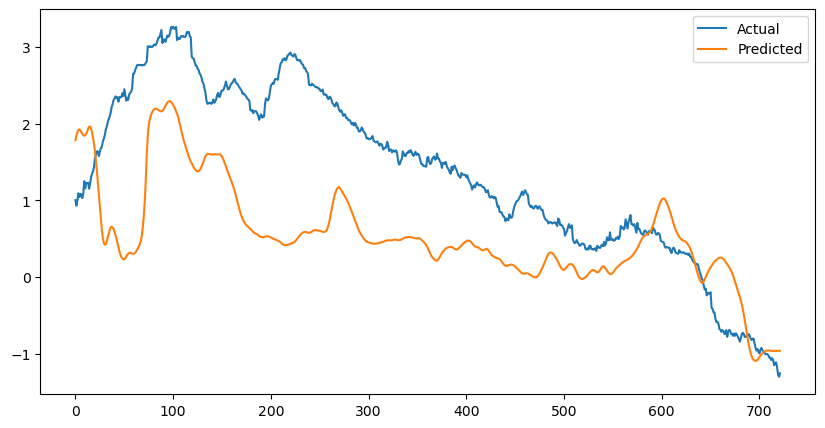

In [46]:
average_model.eval()
with torch.no_grad():
    y_pred_test = average_model(test_tensor_seq4)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels4[:, 1,:].cpu().numpy(), label="Actual")
plt.plot(y_pred_test[:, 1, :].cpu().numpy(), label="Predicted")
plt.legend()
plt.savefig('model123_avg_fl')

In [47]:
# # model 2 and 3 only
# import copy
# # Average the models
# average_model = copy.deepcopy(model3)
# models = [model3, model2]
# # Compute the average of the parameters
# with torch.no_grad():
#     for params in zip(*[model.parameters() for model in models]):  # Iterate over corresponding parameters
#         avg_param = sum(params) / len(models)  # Element-wise average
#         params[0].copy_(avg_param)  # Assign averaged value to the first model (used as reference)

# # The `average_model` now has the averaged parameters
# average_model.eval()
# with torch.no_grad():
#     y_pred_test = average_model(test_tensor_seq4)

# # Plot test predictions
# plt.figure(figsize=(10, 5))
# plt.plot(test_tensor_labels4[:, 1,:].cpu().numpy(), label="Actual")
# plt.plot(y_pred_test[:, 1, :].cpu().numpy(), label="Predicted")
# plt.legend()


In [48]:
# average_model.eval()
# with torch.no_grad():
#     y_pred_test = average_model(test_tensor_seq4)

# # Plot test predictions
# plt.figure(figsize=(10, 5))
# plt.plot(test_tensor_labels4[0, :,:].cpu().numpy(), label="Actual")
# plt.plot(y_pred_test[0, :, :].cpu().numpy(), label="Predicted")
# plt.legend()
# plt.savefig('model123_avg_fl')

In [49]:
test_tensor_labels4.shape

torch.Size([722, 30, 1])